In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [70]:
ticker = 'SOFI'
df = yf.download(ticker, '2024-01-01')

/var/folders/bq/9j3tgp6x4k7fg5dr9rl7bkk00000gn/T/ipykernel_72433/2957055924.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2024-01-01')
[*********************100%***********************]  1 of 1 completed


In [71]:
df

Price,Close,High,Low,Open,Volume
Ticker,SOFI,SOFI,SOFI,SOFI,SOFI
Date,,,,,
2024-01-02,9.650000,9.815000,9.520000,9.710000,38035000
2024-01-03,8.310000,9.030000,8.280000,8.910000,82970700
2024-01-04,8.420000,8.585000,8.170000,8.350000,37398900
2024-01-05,8.220000,8.500000,8.160000,8.270000,39718000
2024-01-08,8.530000,8.620000,8.230000,8.250000,32042200
...,...,...,...,...,...
2025-10-13,27.139999,27.430000,26.469999,27.070000,62676100
2025-10-14,27.870001,28.350000,25.750000,26.510000,75502500


<Axes: xlabel='Date'>

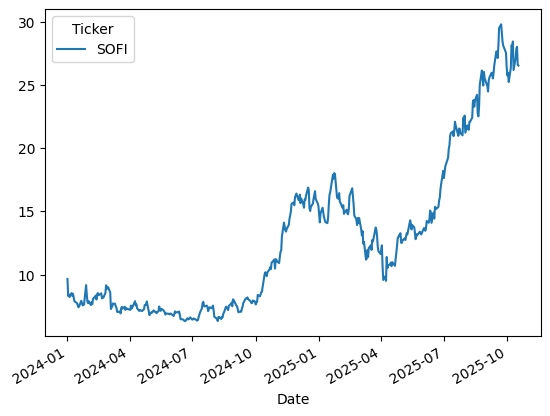

In [72]:
df.Close.plot()

In [73]:
scaler = StandardScaler()
df['Close'] = scaler.fit_transform(df['Close'])

In [74]:
df.Close

Ticker,SOFI
Date,
2024-01-02,-0.508051
2024-01-03,-0.723618
2024-01-04,-0.705922
2024-01-05,-0.738097
2024-01-08,-0.688227
...,...
2025-10-13,2.305583
2025-10-14,2.423019
2025-10-15,2.448759


In [75]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)


In [76]:
train_size = int(0.8 * len(data))
x_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
x_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [77]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out

In [78]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [79]:
criterion = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=0.01)

In [80]:
num_epoch = 200

for i in range(num_epoch):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0:
        print(i, loss)


    opt.zero_grad()
    loss.backward()
    opt.step()
        

0 tensor(0.3714, grad_fn=<MseLossBackward0>)
25 tensor(0.0260, grad_fn=<MseLossBackward0>)
50 tensor(0.0104, grad_fn=<MseLossBackward0>)
75 tensor(0.0081, grad_fn=<MseLossBackward0>)
100 tensor(0.0066, grad_fn=<MseLossBackward0>)
125 tensor(0.0053, grad_fn=<MseLossBackward0>)
150 tensor(0.0047, grad_fn=<MseLossBackward0>)
175 tensor(0.0045, grad_fn=<MseLossBackward0>)


In [81]:
model.eval()

y_test_pred = model(x_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

In [82]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])




In [83]:
train_rmse

0.4107648432254791

In [84]:
test_rmse

3.4150543212890625

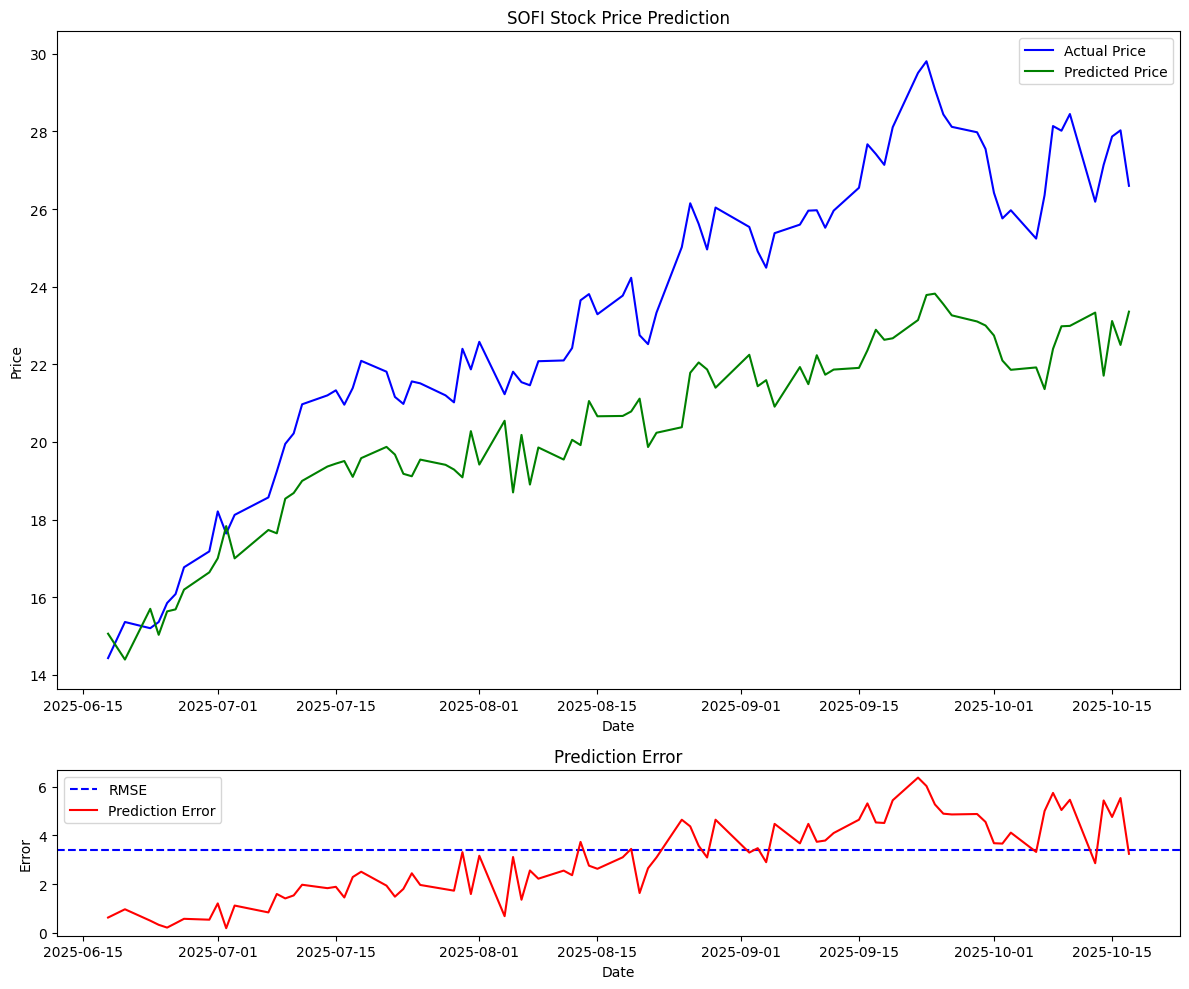

In [85]:
fig = plt.figure(figsize=(12,10))
gs = fig.add_gridspec(4,1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color = 'blue', label= 'Actual Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color = 'green', label= 'Predicted Price')
ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")

ax2 = fig.add_subplot(gs[3,0])
ax2.axhline(test_rmse, color = 'blue', linestyle='--', label = 'RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), 'r', label = 'Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')
plt.tight_layout()
plt.show()
           